In [1]:
# Check pytorch version
import torch

print(torch.__version__)

2.5.1


In [2]:
!nvidia-smi

Wed Dec 11 22:08:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.59                 Driver Version: 556.13         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   49C    P0             19W /   75W |     777MiB /   8188MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")

Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
# Use GPU for training
device = torch.device("cuda")

In [5]:
_exp_name = 'mnist_m'

In [6]:
# Import necessary packages
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, random_split, Dataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from omegaconf import OmegaConf
from tqdm.auto import tqdm
import h5py
import os
import cv2

from rich.progress import Progress, TextColumn, BarColumn, TimeElapsedColumn, TimeRemainingColumn, track

In [7]:
# Fix random seed for reproducibility
seed = 114514
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Avoid nondeterministic algorithms and disable benchmarks for convolution operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
from torchvision import datasets, transforms

# Pipeline for preprocessing of the image. 
source_transform = transforms.Compose([

    # Resize into a fixed size
    transforms.Resize((32, 32)),

    transforms.RandomHorizontalFlip(),
    # Transform to pytorch tensor
    transforms.ToTensor(),

    # Normalizes the pixel values to have a mean value of 0 and a standard deviation of 1, assuming initially in range (0, 1)
    transforms.Normalize((0.5,), (0.5,))
])


# Download the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, transform=source_transform, download=False)
mnist_test = datasets.MNIST(root='./data', train=False, transform=source_transform, download=False)


In [9]:
class MNISTM_dataset(Dataset):
    
    def __init__(self, images, transform=None):

        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):

        image = self.images[index]
        image = self.transform(image)
        return image
    
target_transform = transforms.Compose([

    transforms.ToPILImage(),

    transforms.Grayscale(),

    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    
    transforms.ToPILImage(),
    
    transforms.Resize((32, 32)),

    transforms.RandomHorizontalFlip(),

    transforms.ToTensor(),
])

mnistm_dict = './data/mnistm.h5'
with h5py.File(mnistm_dict, 'r') as h5file:
    mm_train = h5file['train'][:]
    mm_test_data = h5file['test_data'][:]
    mm_test_labels = h5file['test_label'][:]

target_dataset = MNISTM_dataset(mm_train, transform=target_transform)

In [10]:
class MNISTM_test(Dataset):
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        
        image = self.images[index]
        image = self.transform(image)
        label = self.labels[index]
        
        return image, label
    
test_dataset = MNISTM_test(mm_test_data, mm_test_labels, transform=target_transform)

(28, 28, 3)


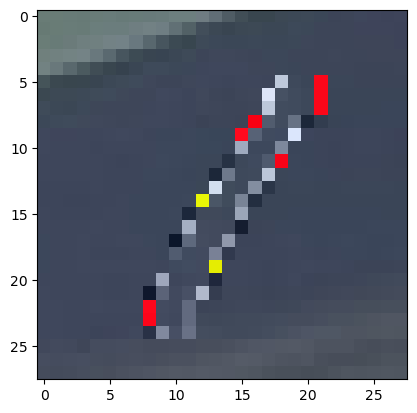

In [14]:
index = 3
# Viualization of certain image
image= mm_train[index]
print(np.shape(image))
plt.imshow(image, cmap="gray")
plt.show()

torch.Size([1, 32, 32])
0


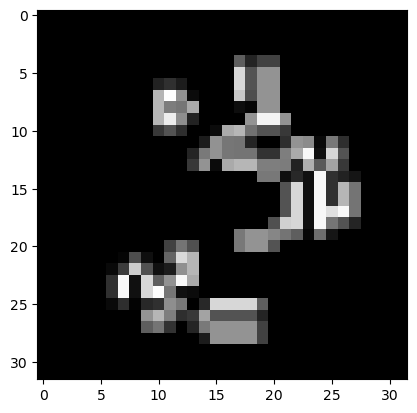

In [12]:
target_image = test_dataset[index]
print(np.shape(target_image[0]))
print(target_image[1])
plt.imshow(target_image[0].squeeze().numpy(), cmap='gray')
plt.show()

In [13]:
config = OmegaConf.load('config_m.yaml')
config_dict = OmegaConf.to_container(config, resolve=True)

In [14]:
# target_len = 10000
# target, _ = random_split(target_dataset, [target_len, len(target_dataset)-target_len])
source_loader = DataLoader(mnist_train, batch_size=config_dict['batch_size'], shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=config_dict['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config_dict['batch_size'], shuffle=False)

In [15]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        # inherit attributes and methods of nn.Module
        super(FeatureExtractor, self).__init__()

        self.cnn = nn.Sequential(
            # Input size is [32, 32, 1]
            self.cnn_layer(in_channels=1, out_channels=64),     # [16, 16, 64]

            self.cnn_layer(in_channels=64, out_channels=128),       # [8, 8, 128]

            self.cnn_layer(in_channels=128, out_channels=256),      # [4, 4, 256]

            self.cnn_layer(in_channels=256, out_channels=512),       # [2, 2, 512]

            self.cnn_layer(in_channels=512, out_channels=512),       # [1, 1, 512]
        )

    def cnn_layer(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, 
                  pooling_kernel_size=2, pooling_stride=2, pooling_padding=0):
        """
        Create a default CNN layer. In and out channels are required parameters
        Parameters:
        - in_channels: Number of input channels.
        - out_channels: Number of output filter channels.
        - kernel_size: Size of the convolutional kernel.
        - stride: Stride of the convolution.
        - padding: Padding value added to the input.
        - pooling_kernel_size: Size of the maxpooling kernel.
        - pooling_stride: Stride of the maxpooling.
        - pooing_padding: Padding value added to the convolution output channel.

        Returns:
        - nn.Sequential: A block with convolution layer and pooling layer.
        """

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            # nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(pooling_kernel_size, pooling_stride, pooling_padding)
        )
    
    def forward(self, x):

        filter = self.cnn(x)
        filter = filter.view(filter.size()[0], -1)

        return filter
    
class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.layer(x)
        return x

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.layer(x)
        return x

In [16]:
feature_extractor = FeatureExtractor().to(device)
label_predictor = LabelPredictor().to(device)
domain_classifier = DomainClassifier().to(device)

label_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = torch.optim.Adam(feature_extractor.parameters(), lr= config_dict['F_lr'])
optimizer_P = torch.optim.Adam(label_predictor.parameters(), lr = config_dict['P_lr'])
optimizer_D = torch.optim.Adam(domain_classifier.parameters(), lr = config_dict['D_lr'])

scheduler_F = torch.optim.lr_scheduler.StepLR(optimizer_F, step_size=5, gamma=config_dict['gamma'])
scheduler_P = torch.optim.lr_scheduler.StepLR(optimizer_P, step_size=5, gamma=config_dict['gamma'])
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=config_dict['gamma'])

In [17]:
def train_epoch(source_loader, target_loader, progress, lamb):

    y_loss = 0.0
    d_loss = 0.0 
    acc_sum = 0.0
    num = 0

    batch_tqdm = progress.add_task(description=f'batch progress', total=len(source_loader))

    for i, ((source_data, source_label), target_data) in enumerate(zip(source_loader, target_loader)):

        source_data = source_data.to(device)
        source_label = source_label.to(device)
        target_data = target_data.to(device)

        mixed_data = torch.cat([source_data, target_data], dim=0)
        mixed_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1])
        mixed_label = mixed_label.to(device)
        mixed_label[:source_data.shape[0]] = 1

        # Train domain classifier
        feature = feature_extractor(mixed_data)
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, mixed_label)
        d_loss += loss.item()
        loss.backward()
        optimizer_D.step()

        # Train feature extractor and label predictor
        label_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        loss = label_criterion(label_logits, source_label) - lamb * domain_criterion(domain_logits, mixed_label)
        y_loss += loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_P.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_P.zero_grad()
        
        acc_sum += torch.sum(torch.argmax(label_logits, dim=1) == source_label).item()
        num += source_data.shape[0]
        progress.advance(batch_tqdm, advance=1)

    progress.remove_task(batch_tqdm)

    return d_loss / (i+1), y_loss / (i+1), acc_sum / num

In [18]:
n_epoches = config_dict['n_epoches']
lamb = config_dict['labmda']

with Progress(TextColumn('[progress.description]{task.description}'),
              BarColumn(),
              TextColumn('[progress.percentage]{task.percentage:3.0f}'),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    
    epoch_tqdm = progress.add_task(description='epoch progress', total=n_epoches)
    for epoch in range(n_epoches):

        feature_extractor.train()
        label_predictor.train()
        domain_classifier.train()

        train_d_loss, train_y_loss, train_acc = train_epoch(source_loader, target_loader, progress, lamb)

        progress.advance(epoch_tqdm, advance=1)

        print('epoch {:3d}: train_d_loss: {:6.4f}, train_y_loss: {:6.4f}, train_acc {:6.4f}'.format(epoch, train_d_loss, train_y_loss, train_acc))

Output()

epoch   0: train_d_loss: 0.6644, train_y_loss: 0.2128, train_acc 0.9089

epoch   1: train_d_loss: 0.5855, train_y_loss: 0.0285, train_acc 0.9744

epoch   2: train_d_loss: 0.6256, train_y_loss: 0.0047, train_acc 0.9799

epoch   3: train_d_loss: 0.5821, train_y_loss: 0.0011, train_acc 0.9831

epoch   4: train_d_loss: 0.5518, train_y_loss: -0.0045, train_acc 0.9853

epoch   5: train_d_loss: 0.5609, train_y_loss: -0.0079, train_acc 0.9864

epoch   6: train_d_loss: 0.5474, train_y_loss: -0.0107, train_acc 0.9872

epoch   7: train_d_loss: 0.5390, train_y_loss: -0.0145, train_acc 0.9887

epoch   8: train_d_loss: 0.5283, train_y_loss: -0.0163, train_acc 0.9899

epoch   9: train_d_loss: 0.5501, train_y_loss: -0.0198, train_acc 0.9895

epoch  10: train_d_loss: 0.5619, train_y_loss: -0.0242, train_acc 0.9909

epoch  11: train_d_loss: 0.5440, train_y_loss: -0.0232, train_acc 0.9908

epoch  12: train_d_loss: 0.5637, train_y_loss: -0.0250, train_acc 0.9917

epoch  13: train_d_loss: 0.5553, train_y_loss: -0.0274, train_acc 0.9919

epoch  14: train_d_loss: 0.5623, train_y_loss: -0.0322, train_acc 0.9932

epoch  15: train_d_loss: 0.5582, train_y_loss: -0.0331, train_acc 0.9934

epoch  16: train_d_loss: 0.5642, train_y_loss: -0.0340, train_acc 0.9936

epoch  17: train_d_loss: 0.5753, train_y_loss: -0.0346, train_acc 0.9937

epoch  18: train_d_loss: 0.5713, train_y_loss: -0.0357, train_acc 0.9941

epoch  19: train_d_loss: 0.5700, train_y_loss: -0.0364, train_acc 0.9942

epoch  20: train_d_loss: 0.5741, train_y_loss: -0.0374, train_acc 0.9942

epoch  21: train_d_loss: 0.5713, train_y_loss: -0.0414, train_acc 0.9957

epoch  22: train_d_loss: 0.5776, train_y_loss: -0.0407, train_acc 0.9956

epoch  23: train_d_loss: 0.5772, train_y_loss: -0.0402, train_acc 0.9953

epoch  24: train_d_loss: 0.5803, train_y_loss: -0.0409, train_acc 0.9954

epoch  25: train_d_loss: 0.5771, train_y_loss: -0.0414, train_acc 0.9952

epoch  26: train_d_loss: 0.5738, train_y_loss: -0.0427, train_acc 0.9958

epoch  27: train_d_loss: 0.5847, train_y_loss: -0.0452, train_acc 0.9962

epoch  28: train_d_loss: 0.5834, train_y_loss: -0.0463, train_acc 0.9967

epoch  29: train_d_loss: 0.5890, train_y_loss: -0.0451, train_acc 0.9964

epoch  30: train_d_loss: 0.5855, train_y_loss: -0.0442, train_acc 0.9965

epoch  31: train_d_loss: 0.6084, train_y_loss: -0.0475, train_acc 0.9962

epoch  32: train_d_loss: 0.5914, train_y_loss: -0.0475, train_acc 0.9969

epoch  33: train_d_loss: 0.5899, train_y_loss: -0.0452, train_acc 0.9967

epoch  34: train_d_loss: 0.5988, train_y_loss: -0.0492, train_acc 0.9970

epoch  35: train_d_loss: 0.5889, train_y_loss: -0.0472, train_acc 0.9969

epoch  36: train_d_loss: 0.5957, train_y_loss: -0.0488, train_acc 0.9973

epoch  37: train_d_loss: 0.5956, train_y_loss: -0.0483, train_acc 0.9971

epoch  38: train_d_loss: 0.5971, train_y_loss: -0.0484, train_acc 0.9972

epoch  39: train_d_loss: 0.5929, train_y_loss: -0.0499, train_acc 0.9976

epoch  40: train_d_loss: 0.6054, train_y_loss: -0.0498, train_acc 0.9971

epoch  41: train_d_loss: 0.6035, train_y_loss: -0.0513, train_acc 0.9976

epoch  42: train_d_loss: 0.6069, train_y_loss: -0.0492, train_acc 0.9972

epoch  43: train_d_loss: 0.6082, train_y_loss: -0.0526, train_acc 0.9979

epoch  44: train_d_loss: 0.6090, train_y_loss: -0.0527, train_acc 0.9978

epoch  45: train_d_loss: 0.6117, train_y_loss: -0.0526, train_acc 0.9980

epoch  46: train_d_loss: 0.6146, train_y_loss: -0.0516, train_acc 0.9977

epoch  47: train_d_loss: 0.6085, train_y_loss: -0.0516, train_acc 0.9980

epoch  48: train_d_loss: 0.6107, train_y_loss: -0.0539, train_acc 0.9980

epoch  49: train_d_loss: 0.6110, train_y_loss: -0.0533, train_acc 0.9979

epoch  50: train_d_loss: 0.6222, train_y_loss: -0.0536, train_acc 0.9978

epoch  51: train_d_loss: 0.6228, train_y_loss: -0.0548, train_acc 0.9981

epoch  52: train_d_loss: 0.6289, train_y_loss: -0.0546, train_acc 0.9980

epoch  53: train_d_loss: 0.6269, train_y_loss: -0.0545, train_acc 0.9981

epoch  54: train_d_loss: 0.6264, train_y_loss: -0.0536, train_acc 0.9978

epoch  55: train_d_loss: 0.6164, train_y_loss: -0.0550, train_acc 0.9983

epoch  56: train_d_loss: 0.6229, train_y_loss: -0.0536, train_acc 0.9980

epoch  57: train_d_loss: 0.6249, train_y_loss: -0.0555, train_acc 0.9982

epoch  58: train_d_loss: 0.6232, train_y_loss: -0.0552, train_acc 0.9982

epoch  59: train_d_loss: 0.6244, train_y_loss: -0.0552, train_acc 0.9981

epoch  60: train_d_loss: 0.6265, train_y_loss: -0.0560, train_acc 0.9984

epoch  61: train_d_loss: 0.6216, train_y_loss: -0.0553, train_acc 0.9984

epoch  62: train_d_loss: 0.6240, train_y_loss: -0.0556, train_acc 0.9983

epoch  63: train_d_loss: 0.6300, train_y_loss: -0.0560, train_acc 0.9981

epoch  64: train_d_loss: 0.6261, train_y_loss: -0.0549, train_acc 0.9983

epoch  65: train_d_loss: 0.6237, train_y_loss: -0.0555, train_acc 0.9982

epoch  66: train_d_loss: 0.6198, train_y_loss: -0.0549, train_acc 0.9986

epoch  67: train_d_loss: 0.6321, train_y_loss: -0.0574, train_acc 0.9985

epoch  68: train_d_loss: 0.6491, train_y_loss: -0.0580, train_acc 0.9984

epoch  69: train_d_loss: 0.6300, train_y_loss: -0.0575, train_acc 0.9987

epoch  70: train_d_loss: 0.6261, train_y_loss: -0.0552, train_acc 0.9981

epoch  71: train_d_loss: 0.6408, train_y_loss: -0.0584, train_acc 0.9987

epoch  72: train_d_loss: 0.6354, train_y_loss: -0.0565, train_acc 0.9984

epoch  73: train_d_loss: 0.6335, train_y_loss: -0.0585, train_acc 0.9987

epoch  74: train_d_loss: 0.6489, train_y_loss: -0.0577, train_acc 0.9983

epoch  75: train_d_loss: 0.6379, train_y_loss: -0.0582, train_acc 0.9987

epoch  76: train_d_loss: 0.6270, train_y_loss: -0.0571, train_acc 0.9987

epoch  77: train_d_loss: 0.6396, train_y_loss: -0.0582, train_acc 0.9989

epoch  78: train_d_loss: 0.6416, train_y_loss: -0.0570, train_acc 0.9984

epoch  79: train_d_loss: 0.6439, train_y_loss: -0.0592, train_acc 0.9988

epoch  80: train_d_loss: 0.6415, train_y_loss: -0.0591, train_acc 0.9988

epoch  81: train_d_loss: 0.6376, train_y_loss: -0.0569, train_acc 0.9983

epoch  82: train_d_loss: 0.6380, train_y_loss: -0.0588, train_acc 0.9989

epoch  83: train_d_loss: 0.6466, train_y_loss: -0.0579, train_acc 0.9986

epoch  84: train_d_loss: 0.6318, train_y_loss: -0.0564, train_acc 0.9985

epoch  85: train_d_loss: 0.6321, train_y_loss: -0.0577, train_acc 0.9987

epoch  86: train_d_loss: 0.6390, train_y_loss: -0.0589, train_acc 0.9989

epoch  87: train_d_loss: 0.6392, train_y_loss: -0.0592, train_acc 0.9990

epoch  88: train_d_loss: 0.6484, train_y_loss: -0.0601, train_acc 0.9989

epoch  89: train_d_loss: 0.6418, train_y_loss: -0.0582, train_acc 0.9985

epoch  90: train_d_loss: 0.6422, train_y_loss: -0.0560, train_acc 0.9988

epoch  91: train_d_loss: 0.6439, train_y_loss: -0.0582, train_acc 0.9986

epoch  92: train_d_loss: 0.6495, train_y_loss: -0.0600, train_acc 0.9990

epoch  93: train_d_loss: 0.6518, train_y_loss: -0.0602, train_acc 0.9990

epoch  94: train_d_loss: 0.6456, train_y_loss: -0.0597, train_acc 0.9990

epoch  95: train_d_loss: 0.6476, train_y_loss: -0.0612, train_acc 0.9993

epoch  96: train_d_loss: 0.6427, train_y_loss: -0.0587, train_acc 0.9990

epoch  97: train_d_loss: 0.6494, train_y_loss: -0.0609, train_acc 0.9990

epoch  98: train_d_loss: 0.6438, train_y_loss: -0.0580, train_acc 0.9986

epoch  99: train_d_loss: 0.6468, train_y_loss: -0.0593, train_acc 0.9988

In [19]:
torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
torch.save(label_predictor.state_dict(), f'predictor_model.bin')
torch.save(domain_classifier.state_dict(), f'predictor_model.bin')

In [20]:
acc_sum = 0.0
num = 0.0
prediction = []
domain_prediction = []

feature_extractor.eval()
label_predictor.eval()
domain_classifier.eval()

with Progress(TextColumn('[progress.description]{task.description}'),
              BarColumn(),
              TextColumn('[progress.percentage]{task.percentage:3.0f}'),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    with torch.no_grad():
        test_tqdm = progress.add_task(description='prediction progress', total=len(test_loader))

        for (test_data, test_label) in test_loader:

            test_data, test_label = test_data.to(device), test_label.to(device)
            
            feature = feature_extractor(test_data)
            label_logits = label_predictor(feature)

            domain_logits = domain_classifier(feature)
            domain_pred = torch.sigmoid(domain_logits) > 0.5
            domain_prediction.extend(domain_pred)

            pred = torch.argmax(label_logits, dim=1).cpu().detach().numpy()
            prediction.append(pred)
            acc_sum += torch.sum(torch.argmax(label_logits, dim=1) == test_label).item()
            num += test_data.shape[0]


Output()

In [21]:
accurancy = acc_sum / num
prediction_ = np.concatenate(prediction)

domain_acc = 1 - sum(domain_prediction) / len(domain_prediction)
print(f'Accurancy for domain classification is {domain_acc}')
print(f'Final accurancy is {accurancy}')

Accurancy for domain classification is tensor([0.6077], device='cuda:0')
Final accurancy is 0.4839


In [22]:
class Classfier(nn.Module):
    def __init__(self):
        # inherit attributes and methods of nn.Module
        super(Classfier, self).__init__()

        self.cnn = nn.Sequential(
            # Input size is [32, 32, 1]
            self.cnn_layer(in_channels=1, out_channels=64),     # [16, 16, 64]

            self.cnn_layer(in_channels=64, out_channels=128),       # [8, 8, 128]

            self.cnn_layer(in_channels=128, out_channels=256),      # [4, 4, 256]

            self.cnn_layer(in_channels=256, out_channels=512),       # [2, 2, 512]

            self.cnn_layer(in_channels=512, out_channels=512)        # [1, 1, 512]
        )

        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def cnn_layer(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, 
                  pooling_kernel_size=2, pooling_stride=2, pooling_padding=0):
        """
        Create a default CNN layer. In and out channels are required parameters
        Parameters:
        - in_channels: Number of input channels.
        - out_channels: Number of output filter channels.
        - kernel_size: Size of the convolutional kernel.
        - stride: Stride of the convolution.
        - padding: Padding value added to the input.
        - pooling_kernel_size: Size of the maxpooling kernel.
        - pooling_stride: Stride of the maxpooling.
        - pooing_padding: Padding value added to the convolution output channel.

        Returns:
        - nn.Sequential: A block with convolution layer and pooling layer.
        """

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            # nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(pooling_kernel_size, pooling_stride, pooling_padding)
        )
    
    def forward(self, x):

        filter = self.cnn(x)
        filter = filter.view(filter.size()[0], -1)

        return self.fc(filter)

In [23]:
CNN_model = Classfier().to(device)
# Load the model of the best performance
CNN_model.load_state_dict(torch.load(f"mnist_best.ckpt"))
CNN_model.eval()
test_acc = []

with torch.no_grad():
    
    for batch in tqdm(test_loader):

        data, label = batch
        data, label = data.to(device), label.to(device)

        pred = CNN_model(data.to(device))
        
        acc = (pred.argmax(dim=-1) == label).cpu().float().mean()
        test_acc.append(acc)

test_acc = sum(test_acc) / len(test_acc)
print(f'CNN model accurancy is {test_acc}')

/tmp/ipykernel_317/391167992.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN_model.load_state_dict(torch.load(f"mnist_best.ckpt"))


  0%|          | 0/79 [00:00<?, ?it/s]

CNN model accurancy is 0.09711234271526337
